# Imports

In [ ]:
import os
import numpy as np
import tensorflow as tf
import itertools

import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from IPython.display import display
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img

from time import strftime
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from numpy.random import seed
seed(888)
tf.random.set_seed(404)

# Constants

In [ ]:
LABEL_NAMES = ['Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS

VALIDATION_SIZE = 10000
SMALL_TRAIN_SIZE = 1000

# Get the Data

In [ ]:
(x_train_all, y_train_all), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
type(x_train_all)

numpy.ndarray

# Explore the Data

In [ ]:
x_train_all[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

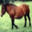

In [ ]:
#First way to show images
pic = array_to_img(x_train_all[7])
display(pic)

In [ ]:
y_train_all.shape

(50000, 1)

In [ ]:
y_train_all[7][0]

7

In [ ]:
LABEL_NAMES[y_train_all[7][0]]

'Horse'

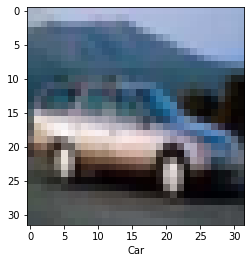

In [ ]:
#Second way to show images
plt.imshow(x_train_all[4])
plt.xlabel(LABEL_NAMES[y_train_all[4][0]])
plt.show()

Writing a for loop to display the first 10 images from the ```x_train_all``` array in a row. Show the name of the label below the picture. Remove the ugly tick marks.

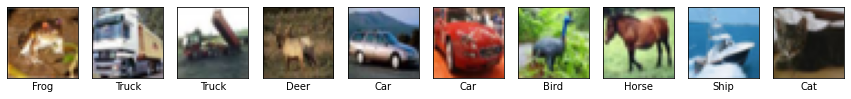

In [ ]:
plt.figure(figsize = (15,5))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.imshow(x_train_all[i])
    plt.xlabel(LABEL_NAMES[y_train_all[i][0]])
    

In [ ]:
x_train_all[0].shape

(32, 32, 3)

In [ ]:
nr_images, x, y, c = x_train_all.shape
print(f'images = {nr_images} \t| width = {x} \t| height = {y} \t| channels = {c}')

images = 50000 	| width = 32 	| height = 32 	| channels = 3


In [ ]:
x_test.shape

(10000, 32, 32, 3)

# Preprocess Data

In [ ]:
#255 va a ser el valor mas alto de mis arrays (por los valores de RGB)
#Divido por 255 para que los valores esten entonces entre 0 y 1, que va a facilitar el calculo de loss y de weights
#Ademas de esta manera cambiamos el tipo de dato a float

x_train_all, x_test = x_train_all / 255.0, x_test /255.0

In [ ]:
type(x_train_all[0][0][0][0])

numpy.float64

In [ ]:
#Aplanar los datos, para que no tenga 4 dimensiones, sino meter todo en 1 sola dimension.
#Para eso multiplico los valores de cada columna que quiero reducir
#Ver seccion CONSTANTS

x_train_all = x_train_all.reshape(x_train_all.shape[0],TOTAL_INPUTS)

In [ ]:
x_train_all.shape

(50000, 3072)

In [ ]:
#Ahora hago lo mismo pero para el test

x_test = x_test.reshape(len(x_test), TOTAL_INPUTS)
print(f'Shape of x_test is {x_test.shape}')

Shape of x_test is (10000, 3072)


# Create Validation Dataset

#### Extracting a portion of Train dataset for Validation.

#### Validation will allow me to select the best model, calculating its parameters and tuning it if it's needed. This way, I'll be choosing the best model without using my Test data yet. The latter will be used in my final evaluation.

In [ ]:
x_val = x_train_all[:VALIDATION_SIZE]
y_val = y_train_all[:VALIDATION_SIZE]
x_val.shape

(10000, 3072)

Creating two arrays ```x_train``` and ```y_train``` that have the shape (40000, 3072) and (40000, 1) respectively. They contain the last 40000 values from ```x_train_all``` and ```y_train_all``` respectively.

In [ ]:
x_train = x_train_all[VALIDATION_SIZE:] #Selecciono los ultimos 40000
y_train = y_train_all[VALIDATION_SIZE:]
x_train.shape

(40000, 3072)

## Create a small dataset (for illustration)

In [ ]:
x_train_xs = x_train[:SMALL_TRAIN_SIZE]
y_train_xs = y_train[:SMALL_TRAIN_SIZE]

# Define the Neural Network using Keras

In [ ]:
#Model Design (inner layers)
model_1 = Sequential([
    Dense(units = 128, input_dim = TOTAL_INPUTS, activation = 'relu', name = 'm1_hidden1'),
    Dense(units = 64, activation = 'relu', name = 'm1_hidden2'),
    Dense(units = 16, activation = 'relu', name = 'm1_hidden3'),
    Dense(units = 10, activation = 'softmax', name = 'm1_output')
])

#Model Compiling (Optimizando el modelo e indicando que calculos debe realizar en cada layer)
model_1.compile(optimizer = 'adam', 
                loss = 'sparse_categorical_crossentropy', 
                metrics = ['accuracy'])

In [ ]:
model_2 = Sequential()
model_2.add(Dropout(0.2, seed = 42, input_shape = (TOTAL_INPUTS,)))
model_2.add(Dense(128, activation = 'relu', name = 'm2_hidden1'))
model_2.add(Dense(64, activation = 'relu', name = 'm2_hidden2'))
model_2.add(Dense(16, activation = 'relu', name = 'm2_hidden3'))
model_2.add(Dense(10, activation = 'softmax', name = 'm2_output'))

model_2.compile(optimizer = 'adam', 
                loss = 'sparse_categorical_crossentropy', 
                metrics = ['accuracy'])

Creating a third model, model_3 that has two droput layers. The second output layer should be added after the first hidden layer and have a dropout rate of 25%

In [ ]:
model_3 = Sequential()
model_3.add(Dropout(0.2, seed = 42, input_shape = (TOTAL_INPUTS,))) #Tecnica para evitar overfitting
model_3.add(Dense(128, activation = 'relu', name = 'm2_hidden1'))
model_3.add(Dropout(0.25, seed = 42))
model_3.add(Dense(64, activation = 'relu', name = 'm2_hidden2'))
model_3.add(Dense(16, activation = 'relu', name = 'm2_hidden3'))
model_3.add(Dense(10, activation = 'softmax', name = 'm2_output'))

model_3.compile(optimizer = 'adam', 
                loss = 'sparse_categorical_crossentropy', 
                metrics = ['accuracy'])

### Categorical Entropy Loss
#### Penalizes the predictions that the model considers trustworthy but are incorrect.

In [ ]:
type(model_1)

keras.engine.sequential.Sequential

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 m1_hidden1 (Dense)          (None, 128)               393344    
                                                                 
 m1_hidden2 (Dense)          (None, 64)                8256      
                                                                 
 m1_hidden3 (Dense)          (None, 16)                1040      
                                                                 
 m1_output (Dense)           (None, 10)                170       
                                                                 
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


# **Fit the Model**

In [ ]:
samples_per_batch = 1000

In [ ]:
# %%time
# nr_epochs = 150
# model_1.fit(x = x_train_xs, y = y_train_xs, batch_size = samples_per_batch, epochs = nr_epochs,
#             verbose = 0)

In [ ]:
#Lo mismo pero agregando tambien la validation data

# %%time
# nr_epochs = 150
# a = model_1.fit(x = x_train_xs, y = y_train_xs, batch_size = samples_per_batch, epochs = nr_epochs,
#             verbose = 1, validation_data = (x_val, y_val))

In [ ]:
#a.history

In [ ]:
#%%time
#nr_epochs = 150
#model_2.fit(x = x_train_xs, y = y_train_xs, batch_size = samples_per_batch, epochs = nr_epochs,
#            verbose = 1, validation_data = (x_val, y_val))

In [ ]:
len(a.history["val_accuracy"])

150

In [ ]:
%%time
nr_epochs = 100
model_1.fit(x = x_train, y = y_train, batch_size = samples_per_batch, epochs = nr_epochs,
            verbose = 1, validation_data = (x_val, y_val))

Epoch 1/100
40/40 [==============================] - 5s 100ms/step - loss: 2.2853 - accuracy: 0.1285 - val_loss: 2.2391 - val_accuracy: 0.1561
Epoch 2/100
40/40 [==============================] - 2s 54ms/step - loss: 2.2044 - accuracy: 0.1995 - val_loss: 2.1569 - val_accuracy: 0.2271
Epoch 3/100
40/40 [==============================] - 2s 62ms/step - loss: 2.1094 - accuracy: 0.2523 - val_loss: 2.0599 - val_accuracy: 0.2530
Epoch 4/100
40/40 [==============================] - 3s 63ms/step - loss: 2.0097 - accuracy: 0.2756 - val_loss: 1.9503 - val_accuracy: 0.2965
Epoch 5/100
40/40 [==============================] - 2s 48ms/step - loss: 1.8776 - accuracy: 0.3225 - val_loss: 1.8217 - val_accuracy: 0.3525
Epoch 6/100
40/40 [==============================] - 2s 48ms/step - loss: 1.7944 - accuracy: 0.3556 - val_loss: 1.7441 - val_accuracy: 0.3746
Epoch 7/100
40/40 [==============================] - 2s 47ms/step - loss: 1.7385 - accuracy: 0.3790 - val_loss: 1.7248 - val_accuracy: 0.3772
Epoch

In [ ]:
%%time
nr_epochs = 100
model_2.fit(x = x_train, y = y_train, batch_size = samples_per_batch, epochs = nr_epochs,
            verbose = 1, validation_data = (x_val, y_val))

Epoch 1/100
40/40 [==============================] - 4s 88ms/step - loss: 2.2318 - accuracy: 0.1675 - val_loss: 2.0984 - val_accuracy: 0.2285
Epoch 2/100
40/40 [==============================] - 3s 78ms/step - loss: 2.0425 - accuracy: 0.2454 - val_loss: 1.9785 - val_accuracy: 0.2675
Epoch 3/100
40/40 [==============================] - 4s 108ms/step - loss: 1.9567 - accuracy: 0.2761 - val_loss: 1.9059 - val_accuracy: 0.3010
Epoch 4/100
40/40 [==============================] - 3s 76ms/step - loss: 1.8984 - accuracy: 0.3015 - val_loss: 1.8628 - val_accuracy: 0.3146
Epoch 5/100
40/40 [==============================] - 3s 77ms/step - loss: 1.8594 - accuracy: 0.3241 - val_loss: 1.8269 - val_accuracy: 0.3311
Epoch 6/100
40/40 [==============================] - 3s 80ms/step - loss: 1.8316 - accuracy: 0.3393 - val_loss: 1.7942 - val_accuracy: 0.3432
Epoch 7/100
40/40 [==============================] - 4s 105ms/step - loss: 1.8044 - accuracy: 0.3495 - val_loss: 1.7741 - val_accuracy: 0.3568
Epoc

In [ ]:
%%time
nr_epochs = 100
model_3.fit(x = x_train, y = y_train, batch_size = samples_per_batch, epochs = nr_epochs,
            verbose = 1, validation_data = (x_val, y_val))

Epoch 1/100
40/40 [==============================] - 4s 89ms/step - loss: 2.2699 - accuracy: 0.1472 - val_loss: 2.1554 - val_accuracy: 0.2059
Epoch 2/100
40/40 [==============================] - 5s 115ms/step - loss: 2.1189 - accuracy: 0.2155 - val_loss: 2.0257 - val_accuracy: 0.2643
Epoch 3/100
40/40 [==============================] - 3s 80ms/step - loss: 2.0180 - accuracy: 0.2653 - val_loss: 1.9179 - val_accuracy: 0.3122
Epoch 4/100
40/40 [==============================] - 3s 80ms/step - loss: 1.9350 - accuracy: 0.2968 - val_loss: 1.8467 - val_accuracy: 0.3385
Epoch 5/100
40/40 [==============================] - 4s 101ms/step - loss: 1.8812 - accuracy: 0.3201 - val_loss: 1.7763 - val_accuracy: 0.3701
Epoch 6/100
40/40 [==============================] - 4s 88ms/step - loss: 1.8450 - accuracy: 0.3330 - val_loss: 1.7442 - val_accuracy: 0.3718
Epoch 7/100
40/40 [==============================] - 3s 79ms/step - loss: 1.8209 - accuracy: 0.3405 - val_loss: 1.7540 - val_accuracy: 0.3660
Epoc

# Predictions on Individual Images

In [ ]:
x_val[0].shape

(3072,)

In [ ]:
test = np.expand_dims(x_val[0], axis = 0) #Hacemos archivo de dos dimensiones con la primera imagen de x_val
test.shape

(1, 3072)

In [ ]:
np.set_printoptions(precision = 3)

In [ ]:
model_2.predict(test)

1/1 [==============================] - 0s 23ms/step


array([[8.450e-03, 1.681e-03, 1.236e-01, 1.742e-01, 1.299e-01, 2.054e-01,
        2.343e-01, 1.211e-01, 1.522e-04, 1.253e-03]], dtype=float32)

In [ ]:
model_2.predict(x_val)

313/313 [==============================] - 1s 4ms/step


array([[8.450e-03, 1.681e-03, 1.236e-01, ..., 1.211e-01, 1.522e-04,
        1.253e-03],
       [1.623e-02, 3.343e-01, 3.513e-03, ..., 5.072e-03, 4.163e-01,
        1.760e-01],
       [2.803e-02, 7.007e-02, 2.689e-03, ..., 1.732e-02, 1.462e-01,
        7.178e-01],
       ...,
       [3.154e-02, 2.011e-01, 2.711e-03, ..., 5.665e-03, 1.932e-01,
        5.535e-01],
       [3.850e-03, 9.365e-01, 1.078e-02, ..., 9.695e-04, 1.633e-02,
        2.057e-02],
       [1.391e-03, 1.123e-04, 1.339e-01, ..., 4.146e-01, 1.005e-04,
        3.733e-04]], dtype=float32)

In [ ]:
model_2.predict(x_val).shape

313/313 [==============================] - 1s 2ms/step


(10000, 10)

In [ ]:
# model_2.predict_classes(test) was deprecated in TensorFlow 2.6
#Pruebo entonces con esto

preds = np.argmax(model_2.predict(test),axis = 1)
preds #El modelo predice que la primera imagen de x_val es la categoria [6]

1/1 [==============================] - 0s 22ms/step


array([6])

In [ ]:
#Para revisar cual es la categoria real, observada en y_val, hacemos lo siguiente
y_val[0]

array([6], dtype=uint8)

Writing a for loop where you print out the actual value and the predicted value for the first 10 images in the valuation dataset (x_val)

In [ ]:
for number in range(10):
  test_img = np.expand_dims(x_val[number], axis = 0)
  predicted_val = np.argmax(model_2.predict(test_img),axis = 1)
  print(f'Actual value: {y_val[number][0]} \nPredicted value: {predicted_val}')


1/1 [==============================] - 0s 51ms/step
Actual value: 6 
Predicted value: [6]
1/1 [==============================] - 0s 22ms/step
Actual value: 9 
Predicted value: [8]
1/1 [==============================] - 0s 21ms/step
Actual value: 9 
Predicted value: [9]
1/1 [==============================] - 0s 27ms/step
Actual value: 4 
Predicted value: [4]
1/1 [==============================] - 0s 29ms/step
Actual value: 1 
Predicted value: [0]
1/1 [==============================] - 0s 26ms/step
Actual value: 1 
Predicted value: [9]
1/1 [==============================] - 0s 50ms/step
Actual value: 2 
Predicted value: [2]
1/1 [==============================] - 0s 34ms/step
Actual value: 7 
Predicted value: [7]
1/1 [==============================] - 0s 43ms/step
Actual value: 8 
Predicted value: [0]
1/1 [==============================] - 0s 25ms/step
Actual value: 3 
Predicted value: [9]


# Evaluation

In [ ]:
model_2.metrics_names

['loss', 'accuracy']

In [ ]:
test_loss, test_accuracy = model_2.evaluate(x_test, y_test)
print(f'Test loss is {test_loss: 0.3} and test accuracy is {test_accuracy: 0.1%}')

313/313 [==============================] - 1s 2ms/step - loss: 1.4628 - accuracy: 0.4764
Test loss is  1.46 and test accuracy is  47.6%


## Confusion Matrix

In [ ]:
predictions = np.argmax(model_2.predict(x_test),axis = 1)
conf_matrix = confusion_matrix(y_true = y_test, y_pred = predictions)

313/313 [==============================] - 1s 3ms/step


In [ ]:
conf_matrix.shape

(10, 10)

In [ ]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

In [ ]:
conf_matrix.max()

694

In [ ]:
conf_matrix.min()

3

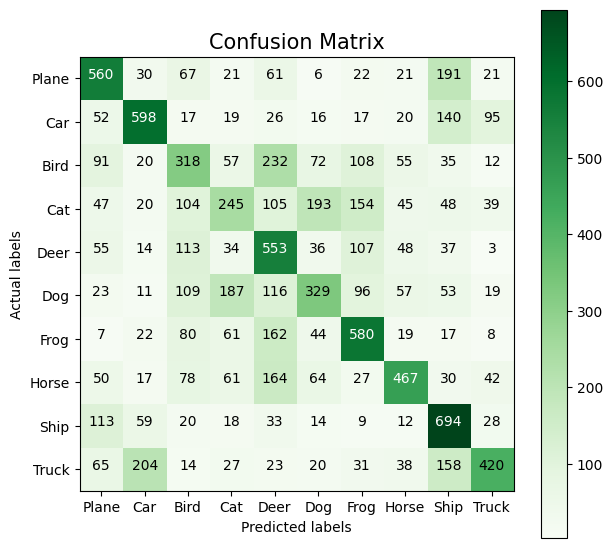

In [ ]:
plt.figure(figsize = (7,7), dpi = 100)
plt.imshow(conf_matrix, cmap = plt.cm.Greens)

plt.title('Confusion Matrix', fontsize = 15)
plt.ylabel('Actual labels')
plt.xlabel('Predicted labels')

tick_marks = np.arange(10)
plt.yticks(tick_marks, LABEL_NAMES)
plt.xticks(tick_marks, LABEL_NAMES)

plt.colorbar()

#Nested loop para colocar los numeros en cada cuadrado de la confusion matrix
for i, j in itertools.product(range(nr_rows), range(nr_cols)):
  plt.text(j, i, conf_matrix[i, j], horizontalalignment = 'center',
           color = 'white' if conf_matrix[i,j] > 450 else 'black')

plt.show()


#### Values on the diagonal are True positives. For example, my model predicted correctly that 560 plane images were in fact a plane. Values outside the diagonal indicate the amount of times the model predicted something that was actually other thing. In the 1st column/2nd row, the model predicted 52 times that an image was a plane, when it actually was a car. All values on that  column outside the diagonal are False positives. False negatives are the values on each row that don't belong to the diagonal.

In [ ]:
### True positives

np.diag(conf_matrix) #Para obtener los valores de la diagonal

array([560, 598, 318, 245, 553, 329, 580, 467, 694, 420])

In [ ]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis = 1)
recall

array([0.56 , 0.598, 0.318, 0.245, 0.553, 0.329, 0.58 , 0.467, 0.694,
       0.42 ])

In [ ]:
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis = 0)
precision

array([0.527, 0.601, 0.346, 0.336, 0.375, 0.414, 0.504, 0.597, 0.495,
       0.611])

In [ ]:
avg_recall = np.mean(recall)
print(f'Model 2 recall score is {avg_recall: .2%}')

Model 2 recall score is  47.64%


In [ ]:
avg_precision = np.mean(precision)
print(f'Model 2 precision score is {avg_precision: .2%}')

Model 2 precision score is  48.05%


In [ ]:
f_score = ((avg_precision * avg_recall) / (avg_precision + avg_recall)) * 2
print(f'Model 2 F score is {f_score: .2%}')

Model 2 F score is  47.85%
